# Genetic Algorithm

Let's try to solve a standard numerical optimization 
$$\max_{x}f(x) \\ \text{subject to } x\in [0,1]^2.$$

### Population

Our population is a collection of $n$ points in $[0,1]^2$. We will initialize by drawing $n$ points from a uniform distribution over the square.

### Fitness

We will measure fitness by evaluation of $f$.

### Selection

We will select the half of our population with the highest fitness. 

### Crossover/Reproduction

We will crossover two individuals by (1) randomly selecting the $x$- or $y$-axis, (2) computing the mean of that coordinate between the two individuals, and (3) moving both individuals to the mean of that coordinate.

### Mutation

We will mutate each offspring by drawing a Bernoulli($p$) random variable. If we draw a $1$, we will add a multivariate normal perturbation to the point.


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker, colors
import time
rng = np.random.default_rng()

In [36]:
"Individual is a point in [0,1] x [0,1]."
class Individual(object):
    x: float
    y: float
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
        return
        
    "Creates an individual with random x and y coordinates."
    @classmethod
    def random(cls):
        return cls(rng.random(), rng.random())
    
    """
    Mutates by adding Gaussian(0,0.1) noise with probability 1/2 and otherwise
    doing nothing.
    """
    def mutate(self):
        if rng.random() > 0.4:
            self.x = min(max(self.x + np.sqrt(0.05) * rng.normal(), 0), 1)
            self.y = min(max(self.y + np.sqrt(0.05) * rng.normal(), 0), 1)
        return
       
    def __str__(self):
        return f"Individual with coordinates ({float(self.x):1.4},{float(self.y):1.4})"
       
    def __repr__(self):
        return str(self)
    
    def __eq__(self, other):
        if not isinstance(other, Individual):
            return False
        return self.x == other.x and self.y == other.y

"""
Turns two Individuals into two new individuals by replacing either both their x-coordinates 
with the average x-coordinate or both y-coordinates, each with probability 1/2
"""
def cross(parent_1, parent_2):
        if rng.random() > 0.5:
            mean_x = (parent_1.x + parent_2.x) / 2
            child_1 = Individual(mean_x, parent_1.y)
            child_2 = Individual(mean_x, parent_2.y)
        else:
            mean_y = (parent_1.y + parent_2.y) / 2
            child_1 = Individual(parent_1.x, mean_y)
            child_2 = Individual(parent_2.x, mean_y)
        return child_1, child_2

    
"Creates n random individuals"
def spawn(individual_class, n):
    return [individual_class.random() for _ in range(n)]


"Finds all the individuals of the population who have at least median fitness"
def selection(objective, population):
    fitnesses = [objective(individual) for individual in population]
    median = np.median(fitnesses)
    survivors = [individual for (individual, fitness) in zip(population, fitnesses) if fitness >= median]
    return survivors

"Creates children by randomly pairing all parents"
def reproduction(cross, parents):
    rng.shuffle(parents)
    if len(parents) % 2 == 1:
        parents.pop()
    children = [child for mates in zip(parents[::2], parents[1::2]) for child in cross(*mates)]
    for child in children:
        child.mutate()
    return children
    
"""
Creates the next generation of a population by performing selection on the current 
generation, creating new children from the survivors, and then either randomly
removing or randomly spawning new individuals to maintain the population size
"""
def evolve(population, size, spawner, selecter, reproducer):
    parents = selecter(population)
    children = reproducer(parents)
    new_population = children + parents
    new_size = len(new_population)
    
    if new_size > size:
        rng.shuffle(new_population)
        new_population = new_population[:size]
    elif new_size < size:
        new_population += spawner(size-new_size)
    
    return new_population

"""
Runs genetic algorithm given a class for creating individuals, an objective function,
a crossover function, a population size, and a number of generations.
"""
def genetic_algorithm(individual_class, objective, cross, size, n_generations):
    def spawner(n): return spawn(individual_class, n)
    def selecter(pop): return selection(objective, pop)
    def reproducer(parents): return reproduction(cross, parents)
    def evolver(pop): return evolve(pop, size, spawner, selecter, reproducer)
    
    population = spawner(size)
    yield population
    for gen in range(n_generations):
        population = evolver(population)
        yield population
    return
    
    

In [37]:
"""
This section of code is to create pseudo-animations of the solution population evolving
"""

from IPython.display import display, clear_output

def pop_to_coords(pop):
    coords = [(ind.x, ind.y) for ind in pop]
    return list(zip(*coords))

def background_plot(f, logscale=False):
    fig, ax = plt.subplots(dpi=400, figsize=(4,3))
    X, Y = np.meshgrid(np.linspace(0,1,200),np.linspace(0,1,200))
    Z = f(X,Y)
    if logscale:
        cs = ax.contourf(X,Y,-Z,locator=ticker.LogLocator())
    else:
        cs = ax.contourf(X,Y,Z)
    cb = fig.colorbar(cs)
    return fig, ax

def animate(objective, background_plotter):
    i = 0
    overall_best = -np.inf
    for pop in genetic_algorithm(Individual, objective, cross, 32, 30):
        if i % 2 == 0:
            cur_best = max([rosenbrock_objective(ind) for ind in pop])
            overall_best = max(overall_best, cur_best)
            fig, ax = background_plotter()
            ax.set_title(f"Generation {i}. Current best {cur_best:1.4}. Overall best {overall_best:1.4}") 
            vals = pop_to_coords(pop)
            ax.scatter(vals[0],vals[1], c="#fd6bbe")
            display(fig)
            clear_output(wait=True)
            plt.pause(0.3)
        i += 1 
    return
    

## Rosenbrock

This test case uses the objective 
$$f(x,y) = x^2 + 40(y - x^2) ^2 $$
(I have shifted and re-scaled to place it in our domain).

In [38]:
def rosenbrock(x, y):
    return -((1/2 - x) ** 2 + 40 * (y - x ** 2) ** 2)

def rosenbrock_objective(individual):
    return rosenbrock(individual.x, individual.y)

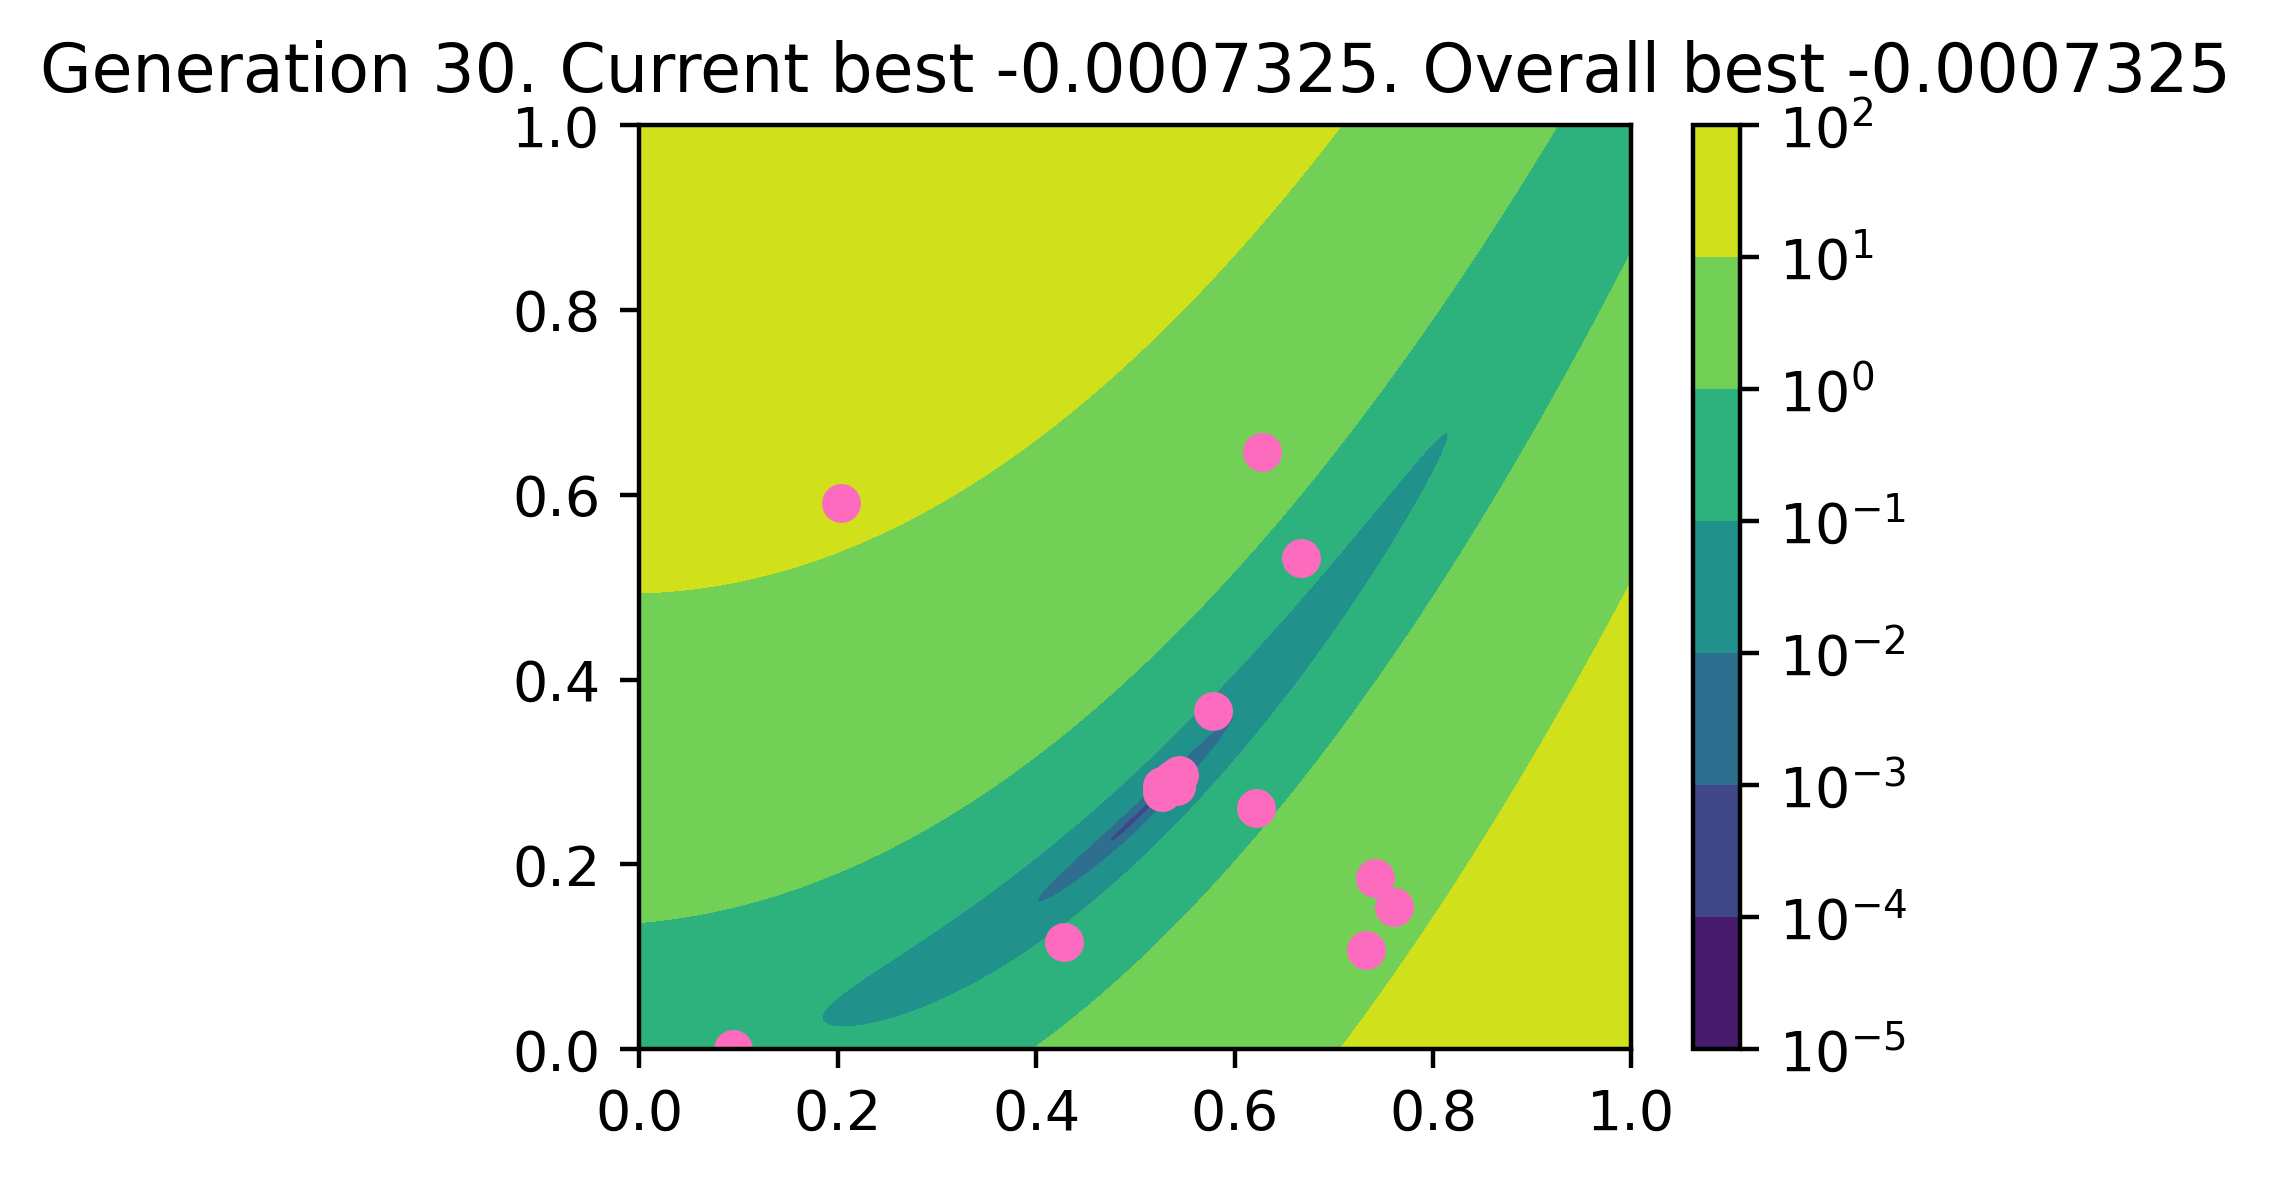

In [40]:
rosenbrock_plotter = lambda : background_plot(rosenbrock, logscale=True)
animate(rosenbrock_objective, rosenbrock_plotter)

## Rastrigin
$$f(x,y) = 2A + x^2 - A\cos(2\pi x) + y^2 - A\cos(2\pi y)$$

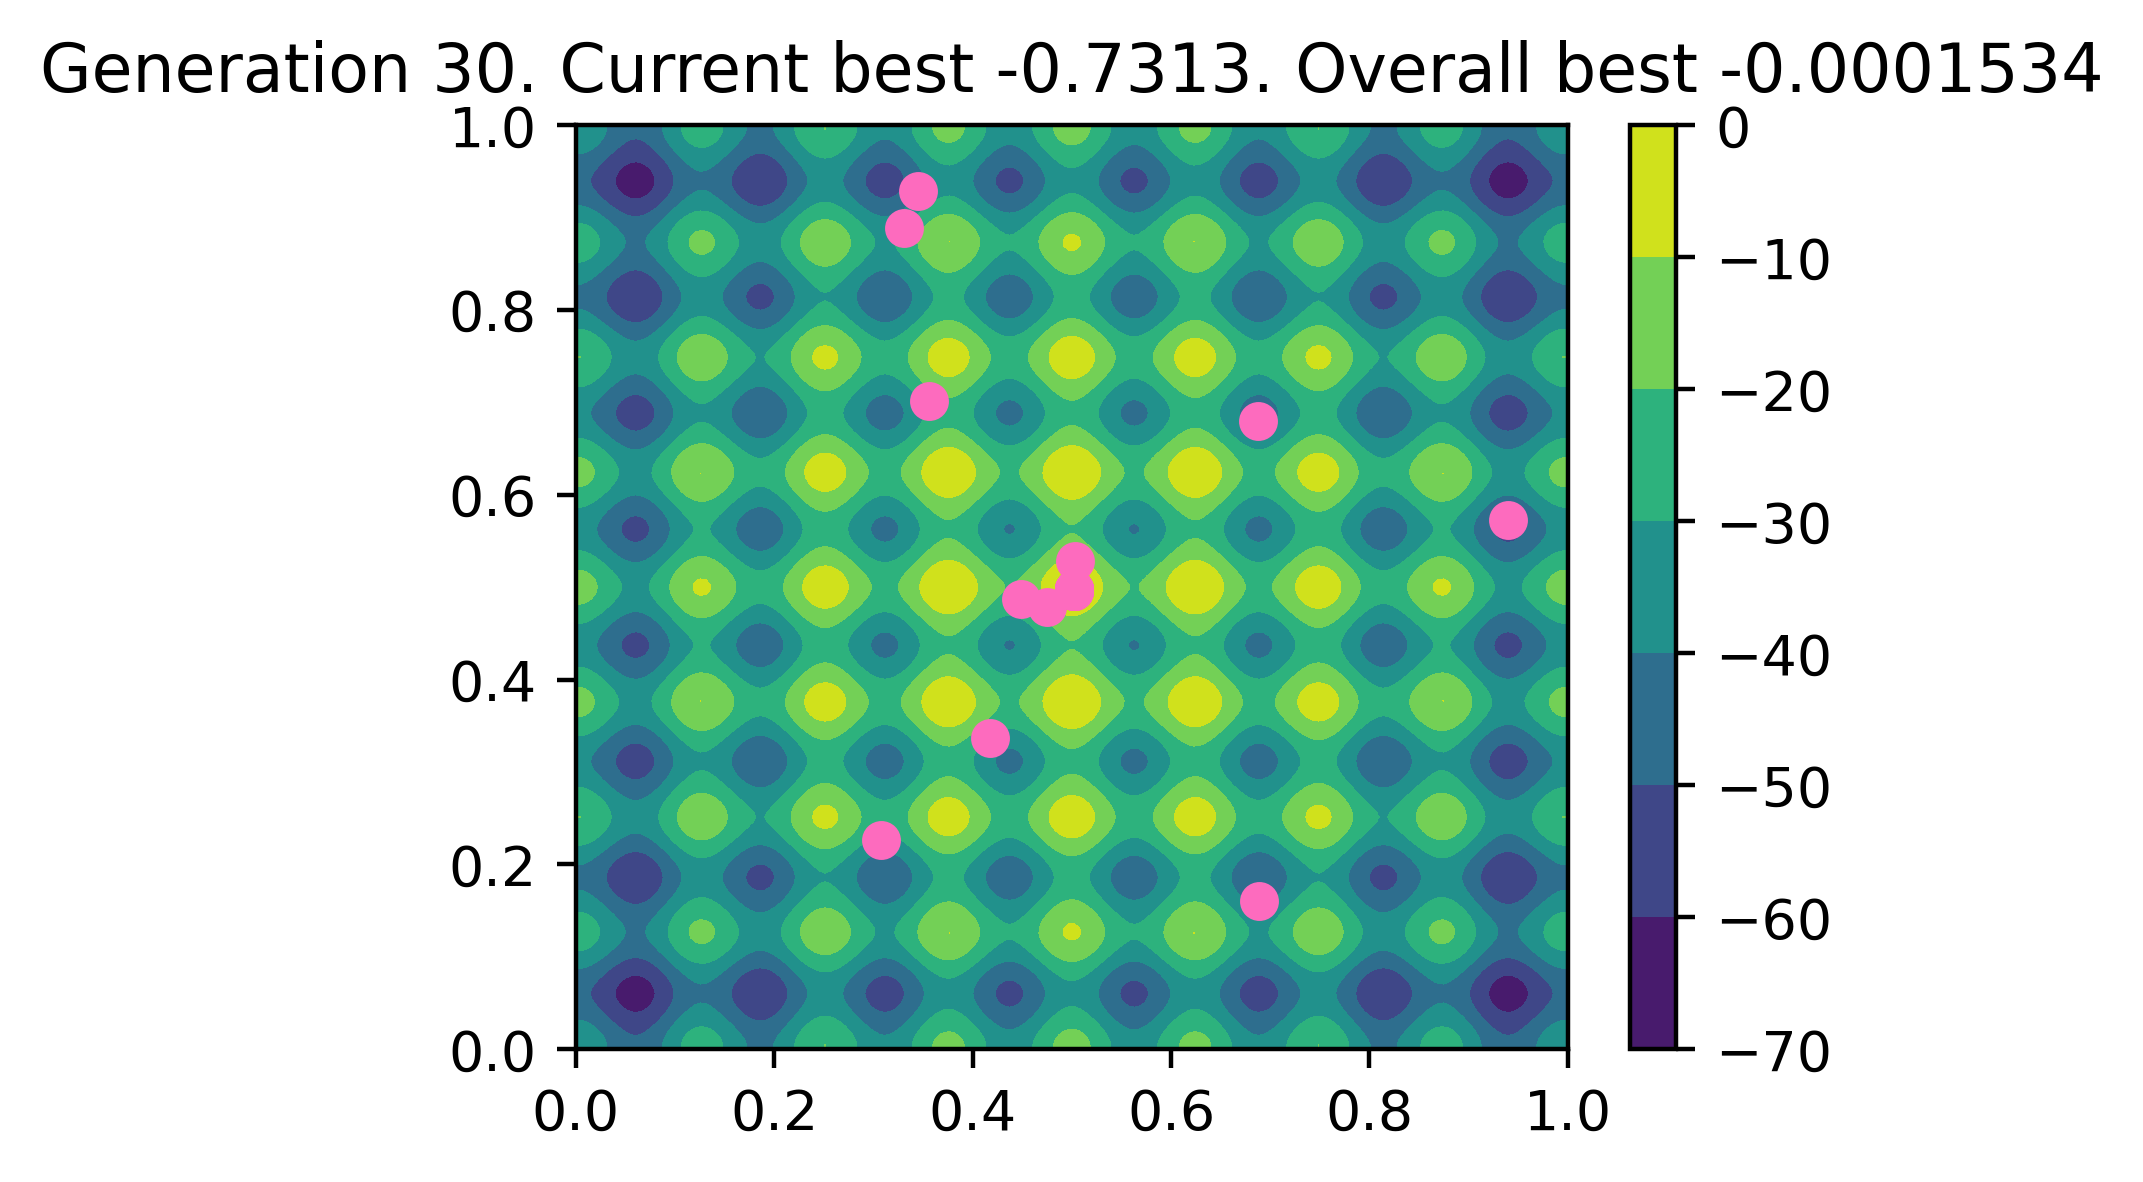

In [42]:
def rastrigin(x, y):
    A = 10
    scale = 8
    x = scale * (x-0.5)
    y = scale * (y-0.5)
    return -(2*A + x ** 2 - A * np.cos(2 * np.pi * x) + y ** 2 - A * np.cos(2 * np.pi * y))

def rastrigin_objective(individual): 
    return rastrigin(individual.x, individual.y)

rastrigin_plotter = lambda : background_plot(rastrigin)
animate(rastrigin_objective, rastrigin_plotter)

In [ ]:
def schaffer(x, y):
    scale = 20
    x = scale * (x-0.5)
    y = scale * (y-0.5)
    return -(0.5 + ((np.sin(x ** 2 - y ** 2) ** 2) - 0.5)/((1 + (x ** 2 + y ** 2)/1000) ** 2))

def schaffer_objective(individual): 
    return schaffer(individual.x, individual.y)

schaffer_plotter = lambda : background_plot(schaffer)
animate(schaffer_objective, schaffer_plotter)

## Himmelbau
$$f(x,y) =  (x^2 + y - 11)^2 + (x + y^2 -7)^2$$

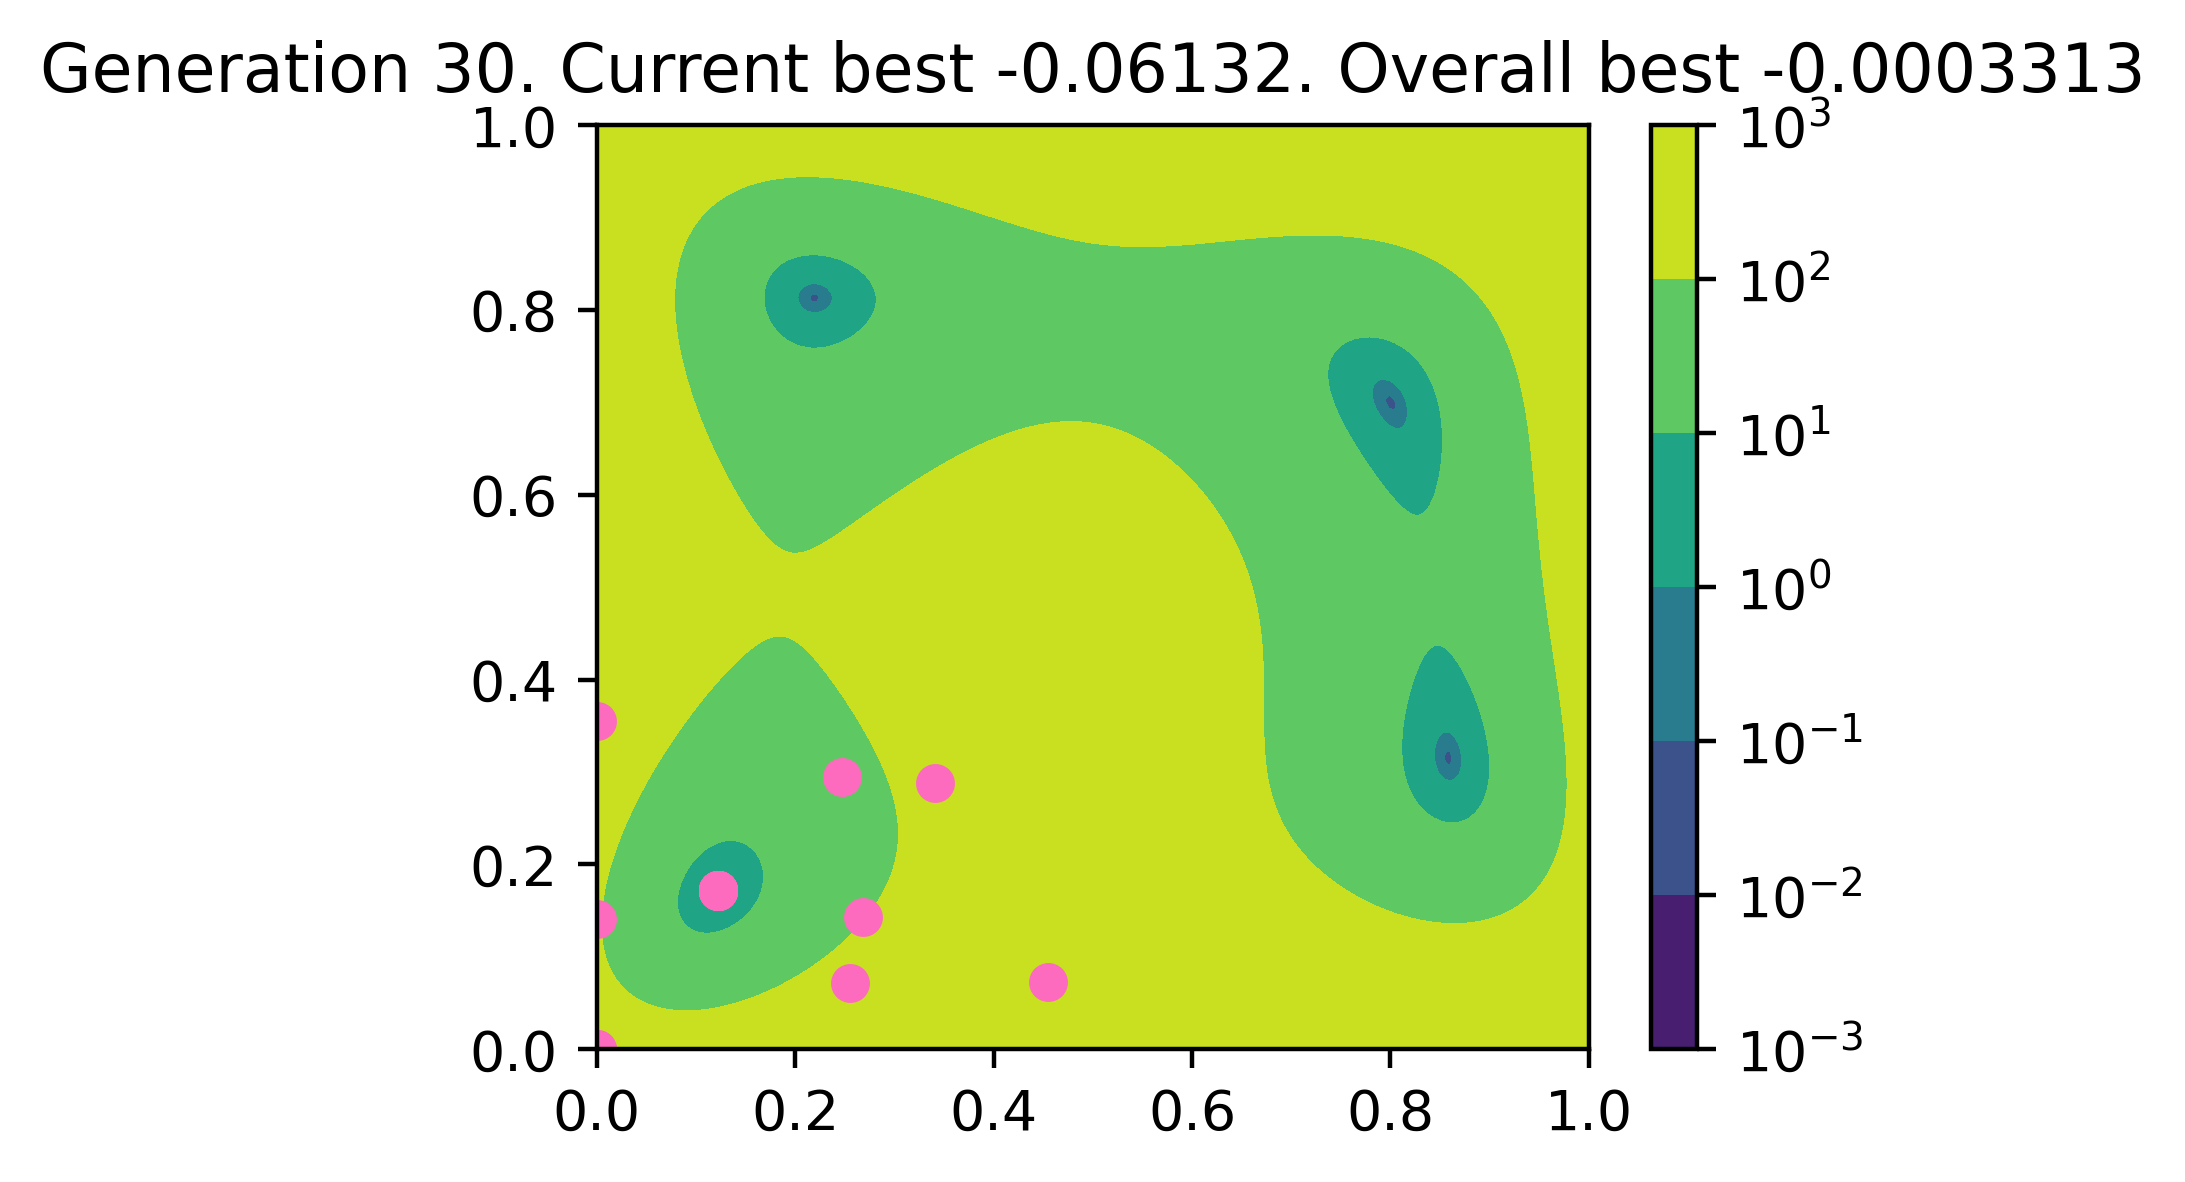

In [44]:
def himmelbau(x, y):
    scale = 10
    x = scale * (x-0.5)
    y = scale * (y-0.5)
    return -((x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2)

def himmelbau_objective(individual): 
    return himmelbau(individual.x, individual.y)

himmelbau_plotter = lambda : background_plot(himmelbau, logscale = True)
animate(himmelbau_objective, himmelbau_plotter)

<br>
<br>
<br>
<br>
<br>
<br>

# Common Modifications

1. __Hill-climbing__: one can add a step (after reproduction/mutation) that performs a local optimization, assuming it is fairly cheap to implement.
2. __Elitism__: one can keep the $k$ highest fitness individuals for the next generation. This may cause convergence to local minima, but it may also save valuable information.
3. __Tournament Selection__: rather than competing all members of the population together, one can compete random pairs of the population (think two organisms fighting for a mate).
4. __Speciation__: keep track of different clusters of solutions in the population. Can penalize mating between similar solutions (incest?).
5. __Adaptive Mutation/Crossover Rates__: can increase/decrease mutation crossover rates according to relative fitness.
5. __Other Strategies__: can select proportionally to fitness, can keep or not keep parents for the next generation, "random immigrants." 


## Strengths

1. Good at avoiding local minima, assuming a good selection of the (many) parameters.
2. Multiple objective optimization is relatively natural by selecting according to what level of Pareto front a point is at.
3. Applies well to discrete problems with large design spaces or odd representations of the solution space (e.g. decision trees, graphs, timetables).
4. Can be robust to changes of objective/constraint if a diverse population is maintained.


## Weaknesses

1. Bad at optimizing locally. Usually the last few "mutations" are hard to find, and other algorithms will perform a better local optimization.
2. May have slow rates of convergence/be computationally expensive (requiring many objective evaluations). An alternative for situations with expensive objective evaluations is Bayesian optimiziation!
3. Problems with few possible fitness values. One is basically just relying on mutations.


## Principles

1. Diversity gives robustness to changes in objective/constraints
2. Maintaining as large of a feasible space as possible. Rather than implementing constraints, implement a penalty.
3. Exploration-Exploitation


# Theoretical results

Some. Usually convergence guarantees for genetic algorithms require problems that have a lot of structure with which one can work. A common technique is to analyze the Markov chain associated to an evolution iteration.


# Standard Applications

1. Scheduling
2. Neural Architecture Search
3. Symbolic Regression


# Software

I am familiar with [PyMOO](https://www.pymoo.org), a fun package that implements a lot of evolutionary algorithms (genetic algorithm, particle-swarm optimization, multi-objective algorithms, etc.)


# Other bio-inspired algorithms

1. Particle swarm optimization
2. Cuckoo search
3. Ant colony optimization
4. Bee colony optimization
5. Firefly algorithm
6. Harmony search
7. Memetic algorithm
8. Cultural algorithm
9. ... and [so on](https://en.wikipedia.org/wiki/List_of_metaphor-based_metaheuristics)